##Model 1 from the paper by Biao and Blangiardo 2006 modified by Daniel Weitzenfeld in his blog post
Orignal Paper: http://www.statistica.it/gianluca/Research/BaioBlangiardo.pdf 

Blog Post: http://danielweitzenfeld.github.io/passtheroc/blog/2014/10/28/bayes-premier-league/

###Model Specification

Number of goals scored by home team in game g is denoted by $y_{home}^{(g)}$. The number of goals scored by the away team in game g is denoted by $y_{away}^{(g)}$. The $y$'s are assumed to follow a Poisson distribution with an unknown rate parameter.

$$ y_{home} | \theta_{home} \sim Poisson(\theta_{home}) $$

$$ y_{away} | \theta_{away} \sim Poisson(\theta_{away}) $$

The rate parameter is assumed to depend on some underlying ability of each time. In the definitions below $h(g)$ denotes the home team for game g and $a(g)$ denotes the away team.

$$ log (\theta_{home}) = home + intercept + att_{h(g)} + def_{a(g)} $$

$$ log  (\theta_{away}) = intercept + att_{a(g)} + def_{h(g)} $$


The $att_t$ and $def_t$ for each team are assumed to be drawn from a normal distribution with mean 0. $\tau$ here represents precision

$$ att_t \sim N(0,1 / \tau_{att}) $$
$$ def_f \sim N(0,1 / \tau_{def}) $$

The model defines non-informative hyper priors on $\tau$, $home$ and $intercept$

$$ \tau_{att} \sim Gamma(0.1,0.1) $$
$$ \tau_{def} \sim Beta(0.1,0.1) $$


$$ home \sim N(0,1000) $$
$$ intercept \sim N(0,1000) $$


The model also constraints the $att_t$ and $def_t$ to sum to 0.

$$ \sum_t att_t = 0 $$

$$ \sum_t def_t = 0 $$



In [28]:
%matplotlib inline
import os
import math
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc
import urllib2
import pymc.graph as pymcgr
from IPython.display import Image

In [29]:
#### Function to get data ###

base_link = "http://www.football-data.co.uk/mmz4281/"

def get_data(base_link,year,league):
    final_link = base_link + year + "/" + league
    filename = year + "_" + league + ".csv"
    
    datafile = urllib2.urlopen(final_link)
    output = open(filename,'wb')
    output.write(datafile.read())
    output.close()
    return pd.read_csv(filename)

def clean_data(matchdata,add_outcomes=True):
    """
    Returns a table of unique teams and a cleaned version of the match results
    """
    # get teams
    t = matchdata.HomeTeam.unique()
    t = pd.DataFrame(t, columns=['team'])
    t['i'] = t.index
    # teams.head()
    
    # merge into original dataframe
    df = matchdata[["HomeTeam","AwayTeam","FTHG","FTAG"]].copy()
    df = pd.merge(df, t, left_on='HomeTeam', right_on='team', how='left')
    df = df.rename(columns = {'i': 'i_home'}).drop('team', 1)
    df = pd.merge(df, t, left_on='AwayTeam', right_on='team', how='left')
    df = df.rename(columns = {'i': 'i_away'}).drop('team', 1)
    df = df.rename(columns = {'FTHG': 'home_goals','FTAG': 'away_goals'})
    
    if add_outcomes:
        df['home_outcome'] = df.apply(lambda x: 'win' if x['home_goals'] > x['away_goals']
                                 else 'loss' if x['home_goals'] < x['away_goals'] else 'draw',axis = 1)
        df['away_outcome'] = df.apply(lambda x: 'win' if x['home_goals'] < x['away_goals']
                                 else 'loss' if x['home_goals'] > x['away_goals'] else 'draw',axis = 1)
    
        df = df.join(pd.get_dummies(df.home_outcome, prefix='home'))
        df = df.join(pd.get_dummies(df.away_outcome, prefix='away'))
    
    return t,df

def create_season_table(season,teams):
    """
    Using a season dataframe output by simulate_season(), create a summary dataframe with wins, losses, goals for, etc.
    
    """
    g = season.groupby('i_home')    
    home = pd.DataFrame({'home_goals': g.home_goals.sum(),
                         'home_goals_against': g.away_goals.sum(),
                         'home_wins': g.home_win.sum(),
                         'home_draws': g.home_draw.sum(),
                         'home_losses': g.home_loss.sum()
                         })
    g = season.groupby('i_away')    
    away = pd.DataFrame({'away_goals': g.away_goals.sum(),
                         'away_goals_against': g.home_goals.sum(),
                         'away_wins': g.away_win.sum(),
                         'away_draws': g.away_draw.sum(),
                         'away_losses': g.away_loss.sum()
                         })
    df = home.join(away)
    df['wins'] = df.home_wins + df.away_wins
    df['draws'] = df.home_draws + df.away_draws
    df['losses'] = df.home_losses + df.away_losses
    df['points'] = df.wins * 3 + df.draws
    df['gf'] = df.home_goals + df.away_goals
    df['ga'] = df.home_goals_against + df.away_goals_against
    df['gd'] = df.gf - df.ga
    df = pd.merge(teams, df, left_on='i', right_index=True)
    df = df.sort_index(by='points', ascending=False)
    df = df.reset_index()
    df['position'] = df.index + 1
    df['champion'] = (df.position == 1).astype(int)
    df['qualified_for_CL'] = (df.position < 5).astype(int)
    df['relegated'] = (df.position > 17).astype(int)
    return df



In [30]:
# get 13-14 data
data_c = get_data(base_link,"1314","E0")
teams, df = clean_data(data_c)

# get 12-13 data
data_p = get_data(base_link,"1213","E0")
teams_p, df_p = clean_data(data_p,add_outcomes=True)

# create season table for 12-13 season to get ranks
season_tbl_p = create_season_table(df_p,teams_p)

# classify teams into groups based on their finish the previous season
num_classes = 1
ranking = season_tbl_p[['team','position']].copy()
ranking['class'] =  np.repeat(np.arange(num_classes),len(ranking.team)/num_classes +1)[:len(ranking.team)]
ranking = ranking.drop('position',axis=1)

# merge with current data to get previous ranking
teams = pd.merge(teams,ranking,how='left',left_on='team',right_on='team')
teams.loc[teams['class'].isnull(),'class'] = num_classes - 1

In [34]:
observed_home_goals = df.home_goals.values
observed_away_goals = df.away_goals.values
home_team = df.i_home.values
away_team = df.i_away.values
team_class = np.array(teams['class'].values,dtype='int')
num_teams = len(df.i_home.unique())
num_games = len(home_team)

g = df.groupby('i_away')
att_starting_points = np.log(g.away_goals.mean())
g = df.groupby('i_home')
def_starting_points = -np.log(g.away_goals.mean())


In [35]:
#hyperpriors
home = pymc.Normal('home', 0, .0001, value=0)
tau_att = pymc.Gamma('tau_att', .1, .1, value=10)
tau_def = pymc.Gamma('tau_def', .1, .1, value=10)
intercept = pymc.Normal('intercept', 0, .0001, value=0)

#team-specific parameters
atts_star = pymc.Normal("atts_star", 
                        mu=0, 
                        tau=tau_att, 
                        size=num_teams, 
                        value=att_starting_points.values)
defs_star = pymc.Normal("defs_star", 
                        mu=0, 
                        tau=tau_def, 
                        size=num_teams, 
                        value=def_starting_points.values) 

# trick to code the sum to zero contraint
@pymc.deterministic
def atts(atts_star=atts_star):
    atts = atts_star.copy()
    atts = atts - np.mean(atts_star)
    return atts

@pymc.deterministic
def defs(defs_star=defs_star):
    defs = defs_star.copy()
    defs = defs - np.mean(defs_star)
    return defs

@pymc.deterministic
def home_theta(home_team=home_team, 
               away_team=away_team, 
               home=home, 
               atts=atts, 
               defs=defs, 
               intercept=intercept): 
    return np.exp(intercept + 
                  home + 
                  atts[home_team] + 
                  defs[away_team])
  
@pymc.deterministic
def away_theta(home_team=home_team, 
               away_team=away_team, 
               home=home, 
               atts=atts, 
               defs=defs, 
               intercept=intercept): 
    return np.exp(intercept + 
                  atts[away_team] + 
                  defs[home_team])   


home_goals = pymc.Poisson('home_goals', 
                          mu=home_theta, 
                          value=observed_home_goals, 
                          observed=True)
away_goals = pymc.Poisson('away_goals', 
                          mu=away_theta, 
                          value=observed_away_goals, 
                          observed=True)

mcmc = pymc.MCMC([home, intercept, tau_att, tau_def, 
                  home_theta, away_theta, 
                  atts_star, defs_star, atts, defs, 
                  home_goals, away_goals])
map_ = pymc.MAP( mcmc )
map_.fit()
mcmc.sample(200000, 40000, 20)

 [-----------------100%-----------------] 200000 of 200000 complete in 125.2 sec

Plotting intercept


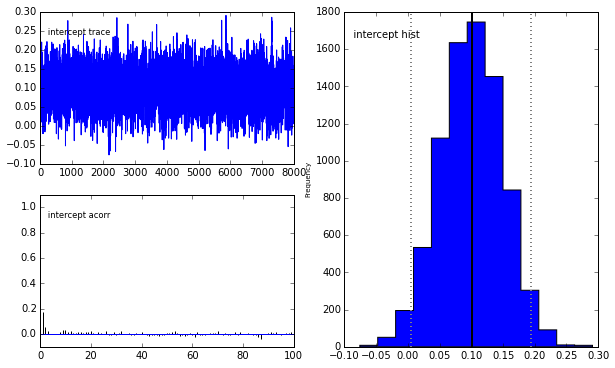

In [36]:
pymc.Matplot.plot(intercept)

Plotting tau_att


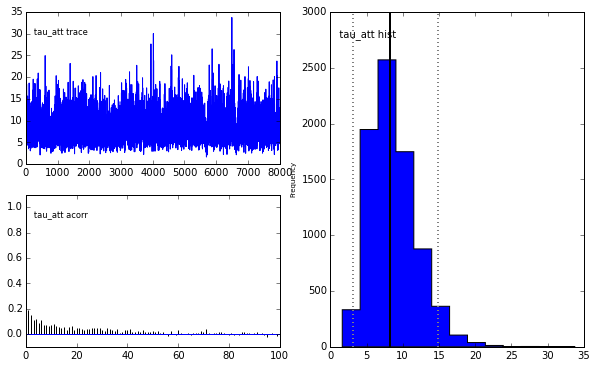

In [37]:
pymc.Matplot.plot(tau_att)

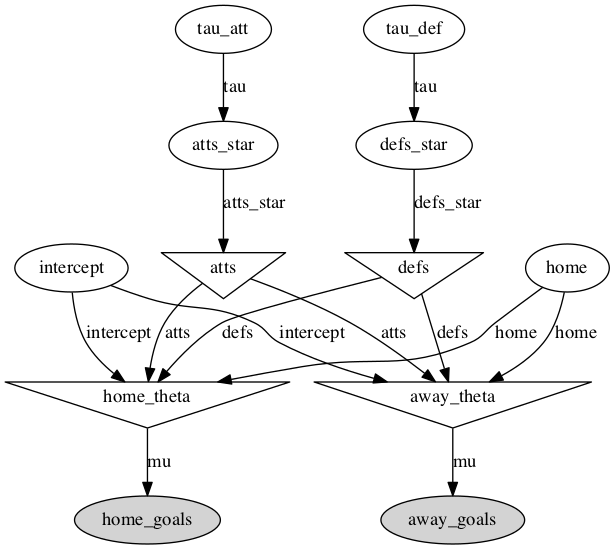

In [38]:
model_graph = pymcgr.graph(mcmc)
Image(model_graph.create_png())

In [39]:
def simulate_season(atts=atts,defs=defs,home=home,intercept=intercept,df=df):
    """
    Simulate a season once, using one random draw from the mcmc chain. 
    """
    num_samples = atts.trace().shape[0]
    draw = np.random.randint(0, num_samples)
    atts_draw = pd.DataFrame({'att': atts.trace()[draw, :],})
    defs_draw = pd.DataFrame({'def': defs.trace()[draw, :],})
    home_draw = home.trace()[draw]
    intercept_draw = intercept.trace()[draw]

    season = df[['i_home','i_away']].copy()
    season = pd.merge(season, atts_draw, left_on='i_home', right_index=True)
    season = pd.merge(season, defs_draw, left_on='i_home', right_index=True)
    season = season.rename(columns = {'att': 'att_home', 'def': 'def_home'})
    season = pd.merge(season, atts_draw, left_on='i_away', right_index=True)
    season = pd.merge(season, defs_draw, left_on='i_away', right_index=True)
    season = season.rename(columns = {'att': 'att_away', 'def': 'def_away'})
    
    
    season['home'] = home_draw
    season['intercept'] = intercept_draw
    season['home_theta'] = season.apply(lambda x: math.exp(x['intercept'] +
                                                           x['home'] + 
                                                           x['att_home'] + 
                                                           x['def_away']), axis=1)
    season['away_theta'] = season.apply(lambda x: math.exp(x['intercept'] +
                                                           x['att_away'] + 
                                                           x['def_home']), axis=1)
    season['home_goals'] = season.apply(lambda x: np.random.poisson(x['home_theta']), axis=1)
    season['away_goals'] = season.apply(lambda x: np.random.poisson(x['away_theta']), axis=1)
    season['home_outcome'] = season.apply(lambda x: 'win' if x['home_goals'] > x['away_goals'] else 
                                                    'loss' if x['home_goals'] < x['away_goals'] else 'draw', axis=1)
    season['away_outcome'] = season.apply(lambda x: 'win' if x['home_goals'] < x['away_goals'] else 
                                                    'loss' if x['home_goals'] > x['away_goals'] else 'draw', axis=1)
    season = season.join(pd.get_dummies(season.home_outcome, prefix='home'))
    season = season.join(pd.get_dummies(season.away_outcome, prefix='away'))
    return season

    
def simulate_seasons(n=100,teams=teams,atts=atts,defs=defs,home=home,intercept=intercept,df=df):
    dfs = []
    for i in range(n):
        s = simulate_season(atts,defs,home,intercept,df)
        t = create_season_table(s,teams)
        t['iteration'] = i
        dfs.append(t)
    return pd.concat(dfs, ignore_index=True)

In [40]:
simuls = simulate_seasons()
g = simuls.groupby('team')
season_hdis = pd.DataFrame({#'points_lower': g.points.quantile(.05),
                            #'points_upper': g.points.quantile(.95),
                            #'goals_for_lower': g.gf.quantile(.05),
                            'goals_for_median': g.gf.median(),
                            #'goals_for_upper': g.gf.quantile(.95),
                            #'goals_against_lower': g.ga.quantile(.05),
                            #'goals_against_upper': g.ga.quantile(.95),
                            })
obs_season = create_season_table(df,teams)


,team,gf,goals_for_median
0,Man City,102,97.0
1,Liverpool,101,94.5
2,Chelsea,71,70.0
3,Arsenal,68,65.0
4,Everton,61,59.5
5,Tottenham,55,53.5
6,Man United,64,63.0
7,Southampton,54,52.0
8,Stoke,45,47.5
9,Newcastle,43,42.0


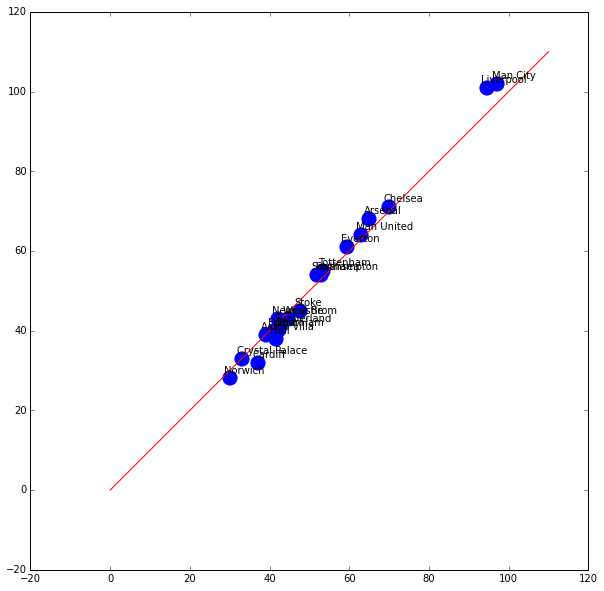

In [42]:
model_comp = pd.merge(obs_season[["team","gf"]],season_hdis,left_on="team",right_index=True)

plt.figure(figsize=(10,10))

plt.scatter(model_comp.goals_for_median.values,model_comp.gf.values,color="blue",s=200)
plt.plot([0,110],[0,110],color="red")

for t,x,y in zip(model_comp.team.values,model_comp.goals_for_median.values,model_comp.gf.values):
#     print t,x,y
    plt.annotate(t, xy=(x,y), xytext = (-5,5), textcoords = 'offset points')

model_comp